## RNN en IMDB

En esta sección se entrena y compara el desempeño de tres redes recurrentes para clasificación de reseñas de películas (IMDB):

- **R1 – SimpleRNN (baseline)**
- **R2 – LSTM + Dropout**
- **R3 – BiLSTM + Dropout**

El objetivo es analizar cómo los cambios en la arquitectura (tipo de celda recurrente, bidireccionalidad y regularización) impactan en las métricas de clasificación:
**accuracy** y **F1-score**.


## Importación de librerías y configuración inicial – RNN IMDB

En esta sección se cargan las librerías necesarias para el desarrollo de los modelos RNN, entre ellas:

- **TensorFlow y Keras** → creación, entrenamiento y evaluación de las redes recurrentes.
- **NumPy** → operaciones numéricas rápidas sobre arreglos.
- **Scikit-learn** → métricas de evaluación adicionales (F1-score) y herramientas de partición.
- **Matplotlib y Pandas** → visualización y reporte de resultados.

También se fija una **semilla aleatoria** con el fin de asegurar reproducibilidad durante el entrenamiento de los modelos R1, R2 y R3, evitando variación excesiva de los resultados entre ejecuciones.

Finalmente, se definen los **parámetros globales** del conjunto de datos IMDB:

- `NUM_WORDS`: tamaño del vocabulario con las palabras más frecuentes del corpus (10,000).
- `MAX_LEN`: número máximo de palabras por reseña tras el preprocesamiento (200).
- `BATCH_SIZE`: tamaño de lote utilizado en todos los experimentos recurrentes (128).

Estos valores se mantendrán constantes en las tres arquitecturas comparadas, permitiendo un análisis justo del impacto de cada cambio de modelo.


In [15]:
# Imports y configuración

import numpy as np
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd

# Semilla fija para que los resultados de las RNN sean reproducibles
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Tamaño máximo del vocabulario (palabras más frecuentes en IMDB)
NUM_WORDS = 10_000

# Longitud máxima de cada reseña (en número de palabras)
MAX_LEN = 200

# Tamaño de lote utilizado en los tres experimentos R1, R2 y R3
BATCH_SIZE = 128


### Carga y preprocesamiento del dataset IMDB

En esta parte se:

- Carga el conjunto de reseñas IMDB limitado a las **10 000 palabras** más frecuentes.
- Aplica **padding** para que todas las reseñas tengan la misma longitud (`MAX_LEN`).
- Separa el conjunto de entrenamiento original en:
  - **Train**: 20 000 reseñas.
  - **Validación**: 5 000 reseñas.
  - El conjunto de **prueba** se deja intacto.
  
De esta forma, las RNN siempre ven la misma partición y se pueden comparar de manera justa.


In [6]:
# 1. Carga y preprocesamiento de IMDB

# Carga reseñas codificadas como secuencias de índices de palabras
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.imdb.load_data(
    num_words=NUM_WORDS
)

# Padding para que todas las secuencias tengan longitud MAX_LEN
x_train_full = keras.preprocessing.sequence.pad_sequences(
    x_train_full, maxlen=MAX_LEN
)
x_test = keras.preprocessing.sequence.pad_sequences(
    x_test, maxlen=MAX_LEN
)

# Se toma una parte para entrenamiento y otra para validación
#  - 20 000 reseñas para train
#  - resto para validación
x_train, x_val = x_train_full[:20_000], x_train_full[20_000:]
y_train, y_val = y_train_full[:20_000], y_train_full[20_000:]

print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_val.shape,  y_val.shape)
print("Test: ", x_test.shape, y_test.shape)


Train: (20000, 200) (20000,)
Val:   (5000, 200) (5000,)
Test:  (25000, 200) (25000,)


### Función auxiliar para entrenar y evaluar modelos RNN

Se define una función genérica que:

1. Compila el modelo con **Adam** y `binary_crossentropy`.
2. Lo entrena con el conjunto de entrenamiento y validación.
3. Mide el **tiempo total de entrenamiento**.
4. Evalúa el modelo en el conjunto de prueba.
5. Calcula las predicciones y muestra el **classification report**, donde aparecen:
   - accuracy
   - precision
   - recall
   - F1-score

La función devuelve el historial de entrenamiento, las métricas de prueba, las
predicciones y el tiempo de entrenamiento en minutos.


In [7]:
# Función auxiliar de entrenamiento y evaluación

def run_experiment_rnn(model, model_id, epochs):
    """
    Compila, entrena y evalúa un modelo RNN para clasificación binaria sobre IMDB.

    Parámetros:
    - model: instancia de keras.Model ya construida.
    - model_id: cadena descriptiva del modelo (para los mensajes).
    - epochs: número de épocas de entrenamiento.

    Devuelve:
    - history: historial de entrenamiento (loss/accuracy).
    - test_acc: accuracy en el conjunto de prueba.
    - test_loss: pérdida en el conjunto de prueba.
    - y_pred: predicciones binarias (0/1) sobre el conjunto de prueba.
    - elapsed_min: tiempo total de entrenamiento en minutos.
    """
    print(f"\n Entrenando modelo {model_id} \n")

    # Compilación del modelo con Adam y entropía cruzada binaria
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    # Se mide el tiempo total de entrenamiento
    start_time = time.time()

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=BATCH_SIZE,
        verbose=2
    )

    end_time = time.time()
    elapsed_min = (end_time - start_time) / 60.0

    # Evaluación en datos de prueba
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"\n[{model_id}] Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

    # Predicciones sobre el conjunto de prueba (probabilidades → 0/1)
    y_prob = model.predict(x_test, verbose=0)
    y_pred = (y_prob > 0.5).astype("int32").reshape(-1)

    print(f"\n[{model_id}] Classification report (Test):\n")
    print(classification_report(y_test, y_pred, digits=4))

    return history, test_acc, test_loss, y_pred, elapsed_min


### Modelo R1 – SimpleRNN (baseline)

Esta primera arquitectura sirve como **línea base**:

- Capa `Embedding(10 000, 64)` para representar palabras como vectores.
- Capa `SimpleRNN(64)` que procesa la secuencia completa.
- Capa `Dense(1, sigmoid)` para clasificación binaria.

Es un modelo sencillo y relativamente rápido, pero con menor capacidad para capturar
dependencias largas en el texto.


In [8]:
# Modelo R1: SimpleRNN baseline

RNN_UNITS_R1 = 64  # número de unidades recurrentes en la capa SimpleRNN

model_r1 = keras.Sequential(
    [
        layers.Embedding(input_dim=NUM_WORDS,
                         output_dim=64,
                         input_length=MAX_LEN),
        layers.SimpleRNN(RNN_UNITS_R1, activation="tanh"),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="r1_simplernn"
)

model_r1.summary()

# Entrenamiento del modelo R1
history_r1, test_acc_r1, test_loss_r1, y_pred_r1, elapsed_r1 = run_experiment_rnn(
    model_r1,
    model_id="R1 SimpleRNN",
    epochs=5
)


Model: "r1_simplernn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 64)           640000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 648321 (2.47 MB)
Trainable params: 648321 (2.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

 Entrenando modelo R1 SimpleRNN 

Epoch 1/5
157/157 - 13s - loss: 0.6329 - accuracy: 0.6185 - val_loss: 0.4790 - val_accuracy: 0.7718 - 13s/epoch - 83ms/step
Epoch 2/5
157/157 - 11s - loss: 0.3663 - accuracy: 0.8436 - val_loss: 0.4093 - val_accuracy: 0.8332 - 11s/epoch - 70ms/step

### Modelo R2 – LSTM + Dropout

En el segundo experimento se reemplaza la celda SimpleRNN por una **LSTM** y se
añade **Dropout** como regularización:

- `Embedding(10 000, 64)`
- `LSTM(128)` para capturar dependencias de largo plazo.
- `Dropout(0.4)` para reducir sobreajuste.
- `Dense(1, sigmoid)`.

Este modelo suele lograr mejor equilibrio entre rendimiento y capacidad de generalización.


In [9]:
# Modelo R2: LSTM + Dropout

LSTM_UNITS_R2 = 128

model_r2 = keras.Sequential(
    [
        layers.Embedding(NUM_WORDS, 64, input_length=MAX_LEN),
        layers.LSTM(LSTM_UNITS_R2, return_sequences=False),
        layers.Dropout(0.4),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="r2_lstm_dropout"
)

model_r2.summary()

history_r2, test_acc_r2, test_loss_r2, y_pred_r2, elapsed_r2 = run_experiment_rnn(
    model_r2,
    model_id="R2 LSTM + Dropout",
    epochs=10
)


Model: "r2_lstm_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 738945 (2.82 MB)
Trainable params: 738945 (2.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

 Entrenando modelo R2 LSTM + Dropout 

Epoch 1/10
157/157 - 69s - loss: 0.4799 - accuracy: 0.7589 - val_loss: 0.3066 - val_accuracy: 0.8696 - 69s/

### Modelo R3 – BiLSTM + Dropout

El tercer modelo extiende a R2 utilizando una **LSTM bidireccional**:

- `Embedding(10 000, 64)`
- `Bidirectional(LSTM(64))` para procesar la reseña en ambas direcciones.
- `Dropout(0.5)` para mayor regularización.
- `Dense(1, sigmoid)`.

La idea es que el modelo tenga más contexto y sea capaz de mejorar la métrica de clasificación,
especialmente en reseñas difíciles.


In [10]:
# Modelo R3: BiLSTM + Dropout

LSTM_UNITS_R3 = 64

model_r3 = keras.Sequential(
    [
        layers.Embedding(NUM_WORDS, 64, input_length=MAX_LEN),
        layers.Bidirectional(layers.LSTM(LSTM_UNITS_R3)),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="r3_bilstm_dropout"
)

model_r3.summary()

history_r3, test_acc_r3, test_loss_r3, y_pred_r3, elapsed_r3 = run_experiment_rnn(
    model_r3,
    model_id="R3 BiLSTM + Dropout",
    epochs=15
)


Model: "r3_bilstm_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 706177 (2.69 MB)
Trainable params: 706177 (2.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

 Entrenando modelo R3 BiLSTM + Dropout 

Epoch 1/15
157/157 - 96s - loss: 0.53

### Comparación gráfica de accuracy y pérdida (R1, R2 y R3)

En este bloque se grafican, para los tres modelos:

- **Accuracy de entrenamiento y validación** por época.
- **Pérdida (loss) de entrenamiento y validación** por época.

Las curvas permiten visualizar si hay **overfitting**, mejoras de convergencia
y diferencias claras entre la línea base y las versiones optimizadas.


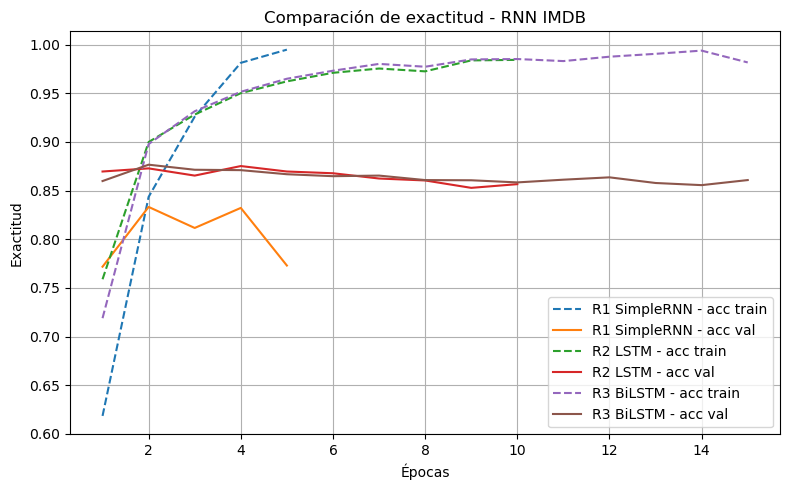

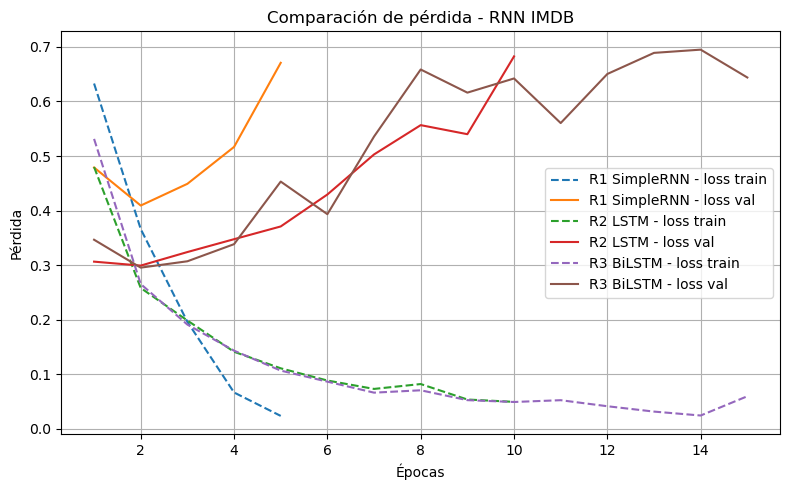

In [11]:
# Gráficas de exactitud y pérdida

def plot_accuracy_histories(histories, labels, title):
    """
    Grafica la exactitud de entrenamiento y validación
    para cada historial de entrenamiento recibido.
    """
    plt.figure(figsize=(8, 5))
    for hist, lab in zip(histories, labels):
        epochs = range(1, len(hist.history["accuracy"]) + 1)
        plt.plot(epochs, hist.history["accuracy"],
                 linestyle="--", label=f"{lab} - acc train")
        plt.plot(epochs, hist.history["val_accuracy"],
                 label=f"{lab} - acc val")
    plt.xlabel("Épocas")
    plt.ylabel("Exactitud")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_loss_histories(histories, labels, title):
    """
    Grafica la pérdida de entrenamiento y validación
    para cada historial de entrenamiento recibido.
    """
    plt.figure(figsize=(8, 5))
    for hist, lab in zip(histories, labels):
        epochs = range(1, len(hist.history["loss"]) + 1)
        plt.plot(epochs, hist.history["loss"],
                 linestyle="--", label=f"{lab} - loss train")
        plt.plot(epochs, hist.history["val_loss"],
                 label=f"{lab} - loss val")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


histories_r = [history_r1, history_r2, history_r3]
labels_r    = ["R1 SimpleRNN", "R2 LSTM", "R3 BiLSTM"]

plot_accuracy_histories(histories_r, labels_r,
                        "Comparación de exactitud - RNN IMDB")
plot_loss_histories(histories_r, labels_r,
                    "Comparación de pérdida - RNN IMDB")


### Análisis de errores con texto decodificado (R1, R2 y R3)

En este bloque se comparan los errores de los tres modelos recurrentes:

- Se identifican las reseñas donde la predicción no coincide con la etiqueta real.
- Para cada modelo (R1, R2 y R3) se muestran algunos ejemplos mal clasificados.
- Cada ejemplo incluye la etiqueta verdadera, la predicción del modelo
  y un fragmento de la reseña decodificada.

Esto permite observar en qué tipo de textos falla cada arquitectura y
comentar posibles limitaciones o patrones de error durante la presentación.


In [12]:
# Análisis de errores con texto decodificado (R1, R2 y R3)

# Se carga el índice de palabras de IMDB para poder reconstruir el texto
word_index = keras.datasets.imdb.get_word_index()

# Diccionario inverso: índice → palabra
reverse_index = {v + 3: k for k, v in word_index.items()}
reverse_index[0] = "<PAD>"
reverse_index[1] = "<START>"
reverse_index[2] = "<UNK>"
reverse_index[3] = "<UNUSED>"

def decode_review(seq):
    """Convierte una secuencia de índices en una reseña legible."""
    return " ".join(reverse_index.get(i, "?") for i in seq)

# Agrupa predicciones y nombres de los modelos
pred_dict = {
    "R1 SimpleRNN": y_pred_r1,
    "R2 LSTM":      y_pred_r2,
    "R3 BiLSTM":    y_pred_r3,
}

# Número de ejemplos a mostrar por modelo
n = 3

for name, y_pred in pred_dict.items():
    print("\n" + "#" * 60)
    print(f"Análisis de errores para {name}")
    
    mis_idx = np.where(y_pred != y_test)[0]
    print("Número de reseñas mal clasificadas:", len(mis_idx))

    if len(mis_idx) == 0:
        continue

    k = min(n, len(mis_idx))
    sample_idx = np.random.choice(mis_idx, k, replace=False)

    for i, idx in enumerate(sample_idx, 1):
        print("-" * 60)
        print(f"Ejemplo {i}")
        print(f"Etiqueta real: {y_test[idx]}  (0=negativa, 1=positiva)")
        print(f"Predicción   : {int(y_pred[idx])}")
        print("\nReseña decodificada (primeros 200 tokens):\n")
        print(decode_review(x_test[idx][:200]))
        print()



############################################################
Análisis de errores para R1 SimpleRNN
Número de reseñas mal clasificadas: 5605
------------------------------------------------------------
Ejemplo 1
Etiqueta real: 0  (0=negativa, 1=positiva)
Predicción   : 1

Reseña decodificada (primeros 200 tokens):

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> i went to see this film over <UNK> men in fact buying the tickets to <UNK> men and going to the other because it looked like a fun movie with action romance thrills <UNK> and exotic locations they had all that but so do a lot of movies with a conception of story br br all i can say is why why why why did they not just make it a straight narrative instead of some sappy flas

### Libro de registro de experimentos RNN 

Para documentar los experimentos se construye una tabla con:

- Identificador del modelo (R1, R2, R3).
- Tipo de arquitectura y número de unidades recurrentes.
- Número de épocas, accuracy en **train** y **validación**.
- **F1-score en test** (métrica recomendada para clasificación binaria).
- Tiempo total de entrenamiento (minutos).
- Una breve observación cualitativa.

La tabla se guarda como `experimentos_rnn.csv`.


In [13]:
# Libro de registro de experimentos RNN (CSV)

experimentos_rnn = []

def registrar_experimento_rnn(ID, Modelo, units, history, y_pred,
                              elapsed_min, obs):
    """
    Registra métricas relevantes para clasificación binaria con RNN:
    accuracy y F1-score.
    """
    acc_train = float(history.history["accuracy"][-1])
    acc_val   = float(history.history["val_accuracy"][-1])
    f1_test   = f1_score(y_test, y_pred)

    experimentos_rnn.append({
        "ID": ID,
        "Modelo": Modelo,
        "Unidades": units,
        "Batch_size": BATCH_SIZE,
        "Epocas": len(history.history["accuracy"]),
        "Acc_train": acc_train,
        "Acc_val":   acc_val,
        "F1_test":   f1_test,
        "Tiempo (min)": round(elapsed_min, 2),
        "Observaciones": obs
    })


registrar_experimento_rnn(
    ID="R1",
    Modelo="SimpleRNN",
    units=RNN_UNITS_R1,
    history=history_r1,
    y_pred=y_pred_r1,
    elapsed_min=elapsed_r1,
    obs="Modelo baseline: rápido pero con menor capacidad para dependencias largas."
)

registrar_experimento_rnn(
    ID="R2",
    Modelo="LSTM + Dropout",
    units=LSTM_UNITS_R2,
    history=history_r2,
    y_pred=y_pred_r2,
    elapsed_min=elapsed_r2,
    obs="LSTM mejora la representación temporal; Dropout ayuda a controlar el sobreajuste."
)

registrar_experimento_rnn(
    ID="R3",
    Modelo="BiLSTM + Dropout",
    units=LSTM_UNITS_R3,
    history=history_r3,
    y_pred=y_pred_r3,
    elapsed_min=elapsed_r3,
    obs="Modelo bidireccional: mejor contexto y rendimiento global en F1."
)

df_rnn = pd.DataFrame(experimentos_rnn)
df_rnn.to_csv("experimentos_rnn.csv", index=False)
df_rnn


,ID,Modelo,Unidades,Batch_size,Epocas,Acc_train,Acc_val,F1_test,Tiempo (min),Observaciones
0,R1,SimpleRNN,64,128,5,0.99480,0.7730,0.776862,0.97,Modelo baseline: rápido pero con menor capacid...
1,R2,LSTM + Dropout,128,128,10,0.98430,0.8566,0.844927,11.85,LSTM mejora la representación temporal; Dropou...
2,R3,BiLSTM + Dropout,64,128,15,0.98165,0.8608,0.852343,26.98,Modelo bidireccional: mejor contexto y rendimi...
